In [1]:
import numpy as np
import math
import nest
import nest.raster_plot
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import rcParams 

nest.ResetKernel()
nest.local_num_threads = 16
nest.resolution = 0.01 # 10 us = minimum audible angle (MAA) increment of 1.25°


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: May  5 2022 07:35:57

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


Sep 19 10:20:39 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.01 ms.


In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def input_set_up(spectro, ms): 
    for r in range(0, len(spectro)-1):
        if spectro[r][ms] > 0:
            r_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*mean_amplitude_r)
            l_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*mean_amplitude_l)

In [3]:
# Variables
tone = 20
angle = 0
max_ild = 2
time_sim = 1000 #us
C_m_bushy = 1

In [4]:
# Fixed
w_head = 22 #cm
v_sound = 33000 #cm/s

ANFs2SBCs_weight = 2.0
ANFs2GBCs_weight = 1.0
GBCs2MNTBCs_weight = 16.0
SBCs2LSO_weight = 16.0
MNTBCs2LSO_weight = -2.0
#SBCs2MSO_weight = 4.0
#MNTBCs2MSO_weights = [0, -2.0, -4.0, -6.0, -8.0, -10.0, -12.0, -14.0, -16.0, -20.0]

mean_rate = 0
mean_amplitude = 1000
noise_rate = 20

n_ANFs = 35000
ANFs2SBCs = 4
ANFs2GBCs = 20
SBCs2LSO = int(ANFs2GBCs/ANFs2SBCs)
n_SBCs = int(n_ANFs/ANFs2SBCs)
n_GBCs = int(n_ANFs/ANFs2GBCs)

In [5]:
freq = np.round(np.logspace(np.log(20),np.log(20000), num = 3500, base = np.exp(1)),2)
channel_x = np.where(freq>=tone)[0][0]
spectro = np.zeros((3500,time_sim))
spectro[channel_x,:] = np.ones(time_sim)

In [6]:
delta_x = (w_head*np.sin(np.deg2rad(angle)))
itd = 1000*delta_x/v_sound #ms
ipds = 2*np.pi*itd*freq/1000
ild = angle*max_ild/90

In [7]:
r_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
            params={'frequency': np.repeat(freq, 10),
                    'phase': np.repeat(np.rad2deg(ipds),10)}) #ITDs

r_ANFs = nest.Create('parrot_neuron', n_ANFs)

r_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                 params = {'C_m': C_m_bushy, 'V_m': -70})

r_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                 params = {'C_m': C_m_bushy, 'V_m': -70})

r_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                 params = {'C_m': C_m_bushy, 'V_m': -70})

r_LSO = nest.Create('iaf_cond_alpha', n_GBCs, 
                 params = {'C_m': C_m_bushy, 'V_m': -70})

l_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
            params={'frequency': np.repeat(freq, 10),
                'phase': 0})

l_ANFs = nest.Create('parrot_neuron',n_ANFs)

l_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                 params = {'C_m': C_m_bushy, 'V_m': -70})

l_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                 params = {'C_m': C_m_bushy, 'V_m': -70})

l_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                 params = {'C_m': C_m_bushy, 'V_m': -70})

l_LSO = nest.Create('iaf_cond_alpha', n_GBCs, 
                 params = {'C_m': C_m_bushy, 'V_m': -70})

ANFs_noise = nest.Create('poisson_generator',1,
                 params = {'rate':noise_rate})

s_rec_r = nest.Create('spike_recorder')
s_rec_l = nest.Create('spike_recorder')

nest.Connect(r_ANFs_amp, r_ANFs, 'one_to_one')
nest.Connect(l_ANFs_amp, l_ANFs, 'one_to_one')

nest.Connect(r_ANFs, s_rec_r, 'all_to_all')
nest.Connect(l_ANFs, s_rec_l, 'all_to_all')

nest.Connect(r_SBCs, s_rec_r, 'all_to_all')
nest.Connect(l_SBCs, s_rec_l, 'all_to_all')

nest.Connect(r_GBCs, s_rec_r, 'all_to_all')
nest.Connect(l_GBCs, s_rec_l, 'all_to_all')

nest.Connect(r_MNTBCs, s_rec_r, 'all_to_all')
nest.Connect(l_MNTBCs, s_rec_l, 'all_to_all')

nest.Connect(r_LSO, s_rec_r, 'all_to_all')
nest.Connect(l_LSO, s_rec_l, 'all_to_all')

for i in range(0, len(spectro)-1):
    if(np.any(spectro[i][:] > 0)):
        nest.Connect(ANFs_noise, r_ANFs[10*i:10*(i+1)], 'all_to_all')
        nest.Connect(ANFs_noise, l_ANFs[10*i:10*(i+1)], 'all_to_all')
        
for i in range(0, n_SBCs):
    nest.Connect(r_ANFs[ANFs2SBCs*i:ANFs2SBCs*(i+1)], r_SBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})
    nest.Connect(l_ANFs[ANFs2SBCs*i:ANFs2SBCs*(i+1)], l_SBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})

for i in range(0, n_GBCs):
    nest.Connect(r_ANFs[ANFs2GBCs*i:ANFs2GBCs*(i+1)], r_GBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})
    nest.Connect(l_ANFs[ANFs2GBCs*i:ANFs2GBCs*(i+1)], l_GBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})

for i in range(0, n_GBCs):
    nest.Connect(r_SBCs[SBCs2LSO*i:SBCs2LSO*(i+1)], r_LSO[i], 'all_to_all', syn_spec = {"weight":SBCs2LSO_weight})
    nest.Connect(l_SBCs[SBCs2LSO*i:SBCs2LSO*(i+1)], l_LSO[i], 'all_to_all', syn_spec = {"weight":SBCs2LSO_weight})    

nest.Connect(r_GBCs, r_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight})
nest.Connect(l_GBCs, l_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight})

nest.Connect(r_MNTBCs, l_LSO, 'one_to_one', syn_spec = {"weight":MNTBCs2LSO_weight})
nest.Connect(l_MNTBCs, r_LSO, 'one_to_one', syn_spec = {"weight":MNTBCs2LSO_weight})

if(angle>=0): 
    mean_amplitude_r = mean_amplitude
    mean_amplitude_l = mean_amplitude/(10**(abs(ild)/20))
else:
    mean_amplitude_l = mean_amplitude
    mean_amplitude_r = mean_amplitude/(10**(abs(ild)/20))
    
for i in range(time_sim):
    input_set_up(spectro,i)
    nest.Simulate(1)


Sep 19 10:21:11 NodeManager::prepare_nodes [Info]: 
    Preparing 1218048 nodes for simulation.

Sep 19 10:21:12 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1218048
    Simulation time (ms): 1
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Sep 19 10:21:12 SimulationManager::run [Info]: 
    Simulation finished.

Sep 19 10:21:12 NodeManager::prepare_nodes [Info]: 
    Preparing 1218048 nodes for simulation.

Sep 19 10:21:12 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1218048
    Simulation time (ms): 1
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Sep 19 10:21:12 SimulationManager::run [Info]: 
    Simulation finished.

Sep 19 10:21:12 NodeManager::prepare_nodes [Info]: 
    Preparing 1218048 nodes for simulation.

Sep 19 10:21:12 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1218048
    Simulation time (ms): 1
    Number of OpenMP threads: 16
    Number of MPI processes:

In [8]:
data_r = s_rec_r.get('events')
data_l = s_rec_l.get('events')

id_r_ANF1 = r_ANFs[0].get('global_id')
id_r_SBC1 = r_SBCs[0].get('global_id')
id_r_GBC1 = r_GBCs[0].get('global_id')
id_r_MNTBC1 = r_MNTBCs[0].get('global_id')
id_r_LSO1 = r_LSO[0].get('global_id')
id_l_ANF1 = l_ANFs[0].get('global_id')
id_l_SBC1 = l_SBCs[0].get('global_id')
id_l_GBC1 = l_GBCs[0].get('global_id')
id_l_MNTBC1 = l_MNTBCs[0].get('global_id')
id_l_LSO1 = l_LSO[0].get('global_id')

In [9]:
active_r_ANFs = np.unique(data_r['senders'][np.where(data_r['senders']<id_r_SBC1)], return_counts = True)[0]
active_r_SBCs = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_SBC1) & (data_r['senders']<id_r_GBC1))], return_counts = True)[0]
active_r_GBCs = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_GBC1) & (data_r['senders']<id_r_MNTBC1))], return_counts = True)[0]
active_r_MNTBCs = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_MNTBC1) & (data_r['senders']<id_r_LSO1))], return_counts = True)[0]
active_r_LSOs = np.unique(data_r['senders'][np.where(data_r['senders']>=id_r_LSO1)], return_counts = True)[0]

In [10]:
active_r_ANFs

array([35001, 35002, 35003, 35004, 35005, 35006, 35007, 35008, 35009,
       35010])

In [11]:
active_l_ANFs = np.unique(data_l['senders'][np.where(data_l['senders']<id_l_SBC1)], return_counts = True)[0]
active_l_SBCs = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_SBC1) & (data_l['senders']<id_l_GBC1))], return_counts = True)[0]
active_l_GBCs = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_GBC1) & (data_l['senders']<id_l_MNTBC1))], return_counts = True)[0]
active_l_MNTBCs = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_MNTBC1) & (data_l['senders']<id_l_LSO1))], return_counts = True)[0]
active_l_LSOs = np.unique(data_l['senders'][np.where(data_l['senders']>=id_l_LSO1)], return_counts = True)[0]

In [16]:
bin_dim = 0.8 #ms

rate_r_ANFs = np.zeros(int(time_sim/bin_dim)-1)
rate_l_ANFs = np.zeros(int(time_sim/bin_dim)-1)

for i in active_r_ANFs:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,time_sim,bin_dim))
    
    rate_r_ANFs = rate_r_ANFs + s_r
    
for i in active_l_ANFs:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,time_sim,bin_dim))
    rate_l_ANFs = rate_l_ANFs + s_l
    
rate_r_ANFs = rate_r_ANFs/len(active_r_ANFs)
rate_l_ANFs = rate_l_ANFs/len(active_l_ANFs)
    
rate_r_SBCs = np.zeros(int(time_sim/bin_dim)-1)
rate_l_SBCs = np.zeros(int(time_sim/bin_dim)-1)

for i in active_r_SBCs:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,time_sim,bin_dim))
    rate_r_SBCs = rate_r_SBCs + s_r
    
for i in active_l_SBCs:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,time_sim,bin_dim))
    rate_l_SBCs = rate_l_SBCs + s_l
    
rate_r_SBCs = rate_r_SBCs/len(active_r_SBCs)
rate_l_SBCs = rate_l_SBCs/len(active_l_SBCs)
    
rate_r_GBCs = np.zeros(int(time_sim/bin_dim)-1)
rate_l_GBCs = np.zeros(int(time_sim/bin_dim)-1)

for i in active_r_GBCs:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,time_sim,bin_dim))
    rate_r_GBCs = rate_r_GBCs + s_r
    
for i in active_l_GBCs:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,time_sim,bin_dim))
    rate_l_GBCs = rate_l_GBCs + s_l
    
rate_r_GBCs = rate_r_GBCs/len(active_r_GBCs)
rate_l_GBCs = rate_l_GBCs/len(active_l_GBCs)

rate_r_MNTBCs = np.zeros(int(time_sim/bin_dim)-1)
rate_l_MNTBCs = np.zeros(int(time_sim/bin_dim)-1)

for i in active_r_MNTBCs:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,time_sim,bin_dim))
    rate_r_MNTBCs = rate_r_MNTBCs + s_r
    
for i in active_l_MNTBCs:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,time_sim,bin_dim))
    rate_l_MNTBCs = rate_l_MNTBCs + s_l

rate_r_MNTBCs = rate_r_MNTBCs/len(active_r_MNTBCs)
rate_l_MNTBCs = rate_l_MNTBCs/len(active_l_MNTBCs)
    
rate_r_LSOs = np.zeros(int(time_sim/bin_dim)-1)
rate_l_LSOs = np.zeros(int(time_sim/bin_dim)-1)

for i in active_r_LSOs:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,time_sim,bin_dim))
    rate_r_LSOs = rate_r_LSOs + s_r
    
for i in active_l_LSOs:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,time_sim,bin_dim))
    rate_l_LSOs = rate_l_LSOs + s_l

rate_r_LSOs = rate_r_LSOs/len(active_r_LSOs)
rate_l_LSOs = rate_l_LSOs/len(active_l_LSOs)

# 100 Hz

Text(0.5, 0, 'Time (ms)')

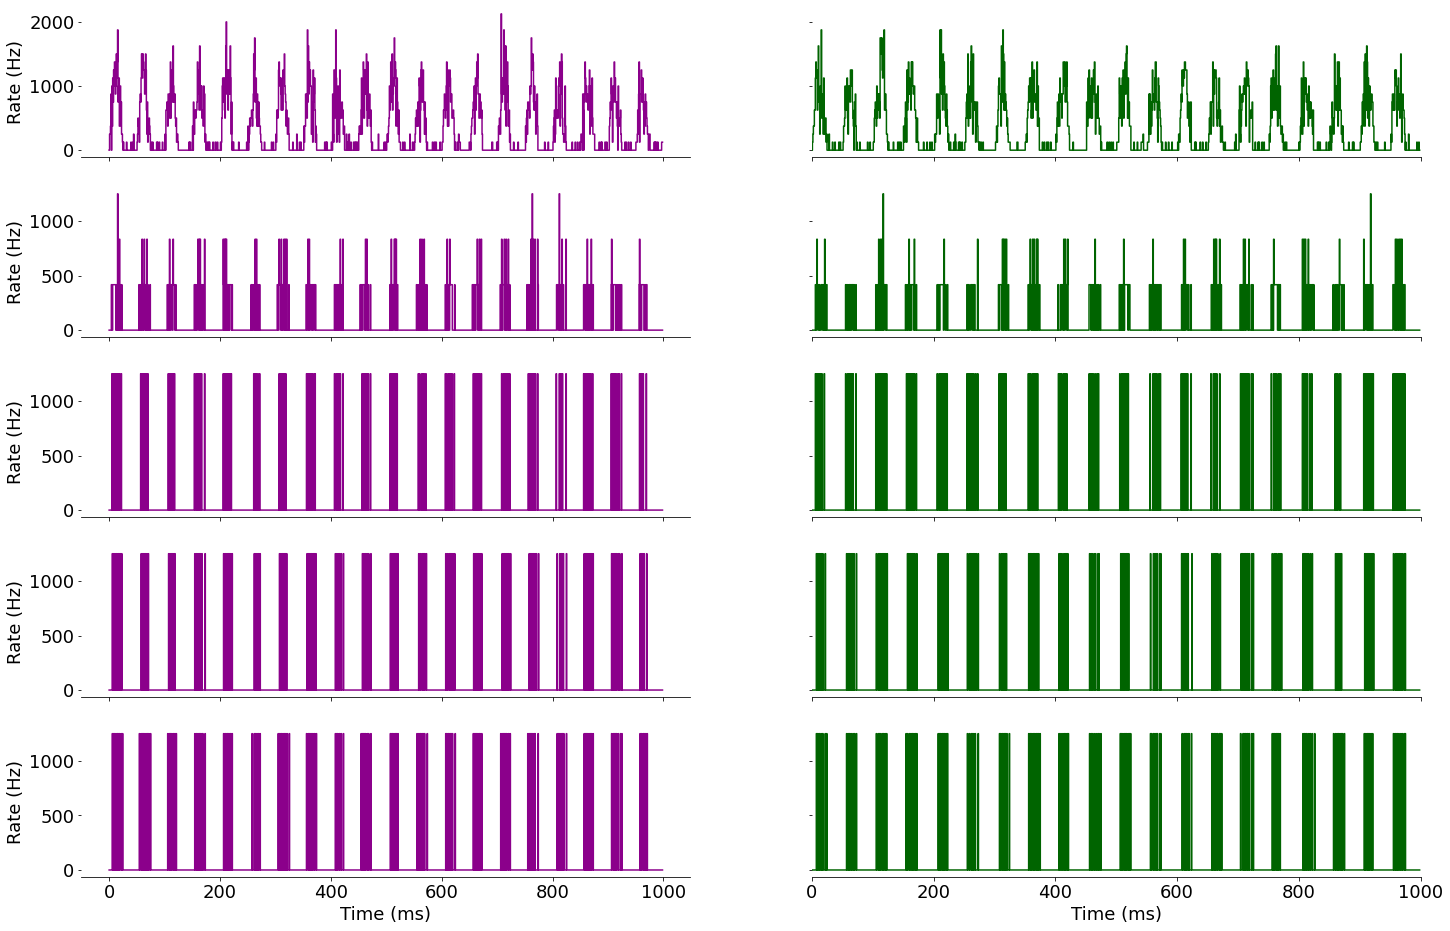

In [17]:
text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

fig, ax = plt.subplots(5,2, figsize = (24,16), sharex = 'col', sharey = 'row')
plt.xlim(0,time_sim)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].step(bins[:-1], rate_l_ANFs*1000/bin_dim, color = 'darkmagenta')
ax[0,0].set_ylabel("Rate (Hz)")

ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].step(bins[:-1], rate_l_SBCs*1000/bin_dim, color = 'darkmagenta')
ax[1,0].set_ylabel("Rate (Hz)")

ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['left'].set_visible(False)
ax[2,0].step(bins[:-1], rate_l_GBCs*1000/bin_dim, color = 'darkmagenta')
ax[2,0].set_ylabel("Rate (Hz)")

ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['left'].set_visible(False)
ax[3,0].step(bins[:-1], rate_l_MNTBCs*1000/bin_dim, color = 'darkmagenta')
ax[3,0].set_ylabel("Rate (Hz)")

ax[4,0].spines['top'].set_visible(False)
ax[4,0].spines['right'].set_visible(False)
ax[4,0].spines['left'].set_visible(False)
ax[4,0].step(bins[:-1], rate_l_LSOs*1000/bin_dim, color = 'darkmagenta')
ax[4,0].set_ylabel("Rate (Hz)")
ax[4,0].set_xlabel("Time (ms)")

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].step(bins[:-1], rate_r_ANFs*1000/bin_dim, color = 'darkgreen')

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].step(bins[:-1], rate_r_SBCs*1000/bin_dim, color = 'darkgreen')

ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)
ax[2,1].step(bins[:-1], rate_r_GBCs*1000/bin_dim, color = 'darkgreen')

ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)
ax[3,1].step(bins[:-1], rate_r_MNTBCs*1000/bin_dim, color = 'darkgreen')

ax[4,1].spines['top'].set_visible(False)
ax[4,1].spines['right'].set_visible(False)
ax[4,1].spines['left'].set_visible(False)
ax[4,1].step(bins[:-1], rate_r_LSOs*1000/bin_dim, color = 'darkgreen')
ax[4,1].set_xlabel("Time (ms)")

Text(0.5, 0, 'Time (ms)')

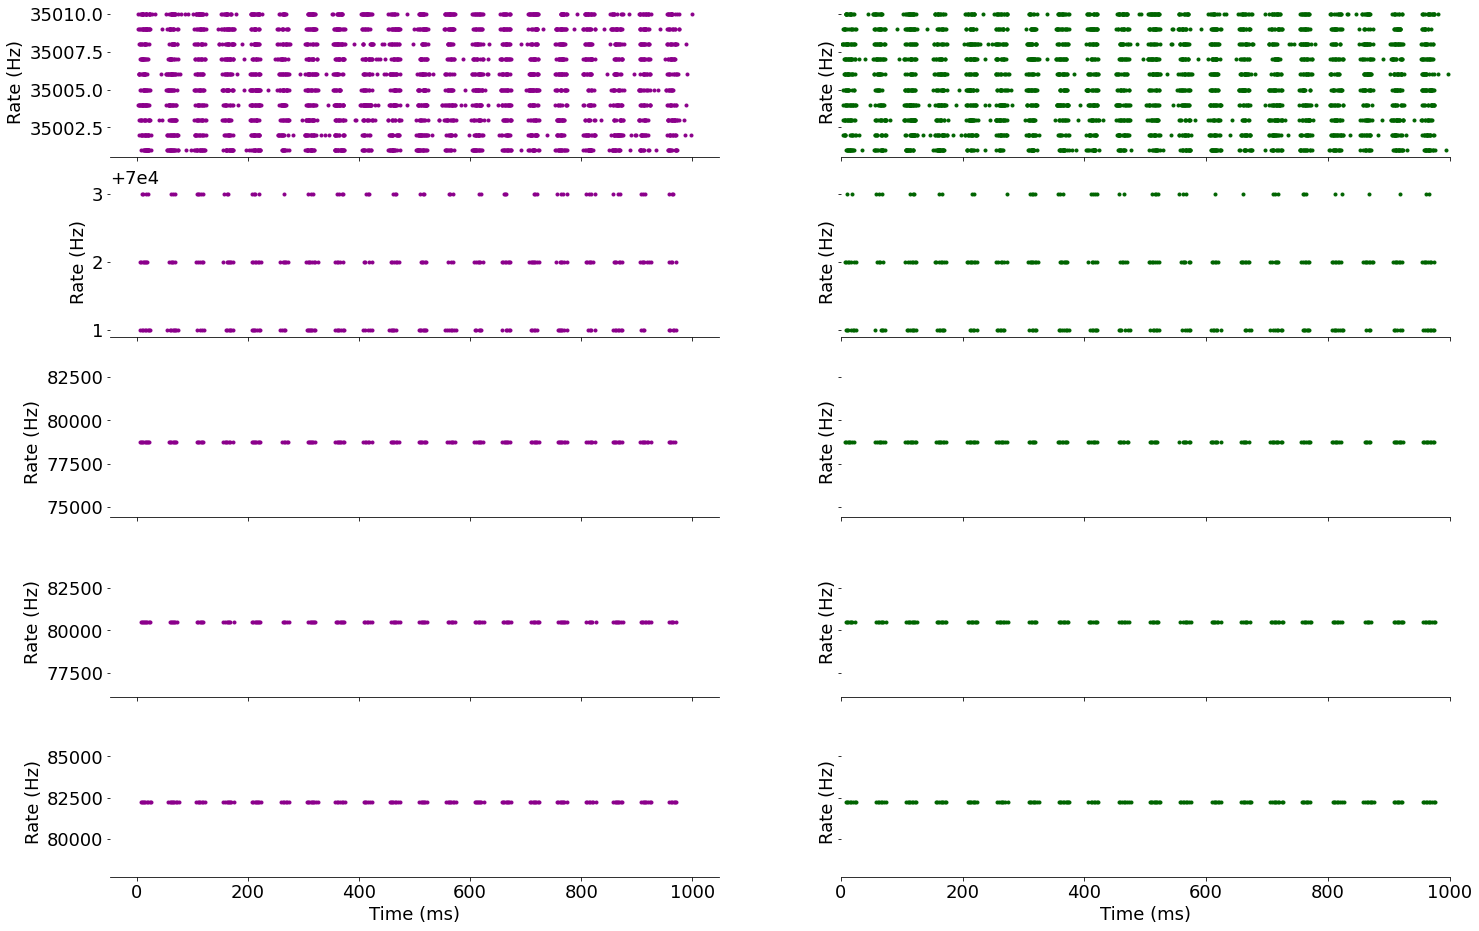

In [18]:
text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

fig, ax = plt.subplots(5,2, figsize = (24,16), sharex = 'col', sharey = 'row')
plt.xlim(0,time_sim)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].plot(data_l['times'][np.where(data_l['senders'] < id_l_SBC1)], data_l['senders'][np.where(data_l['senders'] < id_l_SBC1)] - id_l_ANF1 + id_r_ANF1, ".", color = 'darkmagenta')
ax[0,0].set_ylabel("Rate (Hz)")

ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].plot(data_l['times'][np.where((data_l['senders'] >= id_l_SBC1) & (data_l['senders'] < id_l_GBC1))], data_l['senders'][np.where((data_l['senders'] >= id_l_SBC1) & (data_l['senders'] < id_l_GBC1))]  - id_l_SBC1 + id_r_SBC1, ".", color = 'darkmagenta')
ax[1,0].set_ylabel("Rate (Hz)")

ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['left'].set_visible(False)
ax[2,0].plot(data_l['times'][np.where((data_l['senders'] >= id_l_GBC1) & (data_l['senders'] < id_l_MNTBC1))], data_l['senders'][np.where((data_l['senders'] >= id_l_GBC1) & (data_l['senders'] < id_l_MNTBC1))]  - id_l_GBC1 + id_r_GBC1, ".", color = 'darkmagenta')
ax[2,0].set_ylabel("Rate (Hz)")

ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['left'].set_visible(False)
ax[3,0].plot(data_l['times'][np.where((data_l['senders'] >= id_l_MNTBC1) & (data_l['senders'] < id_l_LSO1))], data_l['senders'][np.where((data_l['senders'] >= id_l_MNTBC1) & (data_l['senders'] < id_l_LSO1))] - id_l_MNTBC1 + id_r_MNTBC1, ".", color = 'darkmagenta')
ax[3,0].set_ylabel("Rate (Hz)")

ax[4,0].spines['top'].set_visible(False)
ax[4,0].spines['right'].set_visible(False)
ax[4,0].spines['left'].set_visible(False)
ax[4,0].plot(data_l['times'][np.where(data_l['senders'] >= id_l_LSO1)], data_l['senders'][np.where(data_l['senders'] >= id_l_LSO1)] - id_l_LSO1 + id_r_LSO1, ".", color = 'darkmagenta')
ax[4,0].set_ylabel("Rate (Hz)")
ax[4,0].set_xlabel("Time (ms)")

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].plot(data_r['times'][np.where(data_r['senders'] < id_r_SBC1)], data_r['senders'][np.where(data_r['senders'] < id_r_SBC1)], ".", color = 'darkgreen')
ax[0,1].set_ylabel("Rate (Hz)")

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].plot(data_r['times'][np.where((data_r['senders'] >= id_r_SBC1) & (data_r['senders'] < id_r_GBC1))], data_r['senders'][np.where((data_r['senders'] >= id_r_SBC1) & (data_r['senders'] < id_r_GBC1))], ".", color = 'darkgreen')
ax[1,1].set_ylabel("Rate (Hz)")

ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)
ax[2,1].plot(data_r['times'][np.where((data_r['senders'] >= id_r_GBC1) & (data_r['senders'] < id_r_MNTBC1))], data_r['senders'][np.where((data_r['senders'] >= id_r_GBC1) & (data_r['senders'] < id_r_MNTBC1))], ".", color = 'darkgreen')
ax[2,1].set_ylabel("Rate (Hz)")

ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)
ax[3,1].plot(data_r['times'][np.where((data_r['senders'] >= id_r_MNTBC1) & (data_r['senders'] < id_r_LSO1))], data_r['senders'][np.where((data_r['senders'] >= id_r_MNTBC1) & (data_r['senders'] < id_r_LSO1))], ".", color = 'darkgreen')
ax[3,1].set_ylabel("Rate (Hz)")

ax[4,1].spines['top'].set_visible(False)
ax[4,1].spines['right'].set_visible(False)
ax[4,1].spines['left'].set_visible(False)
ax[4,1].plot(data_r['times'][np.where(data_r['senders'] >= id_r_LSO1)], data_r['senders'][np.where(data_r['senders'] >= id_r_LSO1)], ".", color = 'darkgreen')
ax[4,1].set_ylabel("Rate (Hz)")
ax[4,1].set_xlabel("Time (ms)")